# Кейс от Megafon

Задачи: 
- Определение вероятности подключения новой определенной услуги для каждой test-пары пользователь-услуга
- Формирование индивидуального предложения абоненту для максимизации выручки

Содержание:
* [Обзор датасета](#data)
* [Дифференцирование и ресемплинг рядов](#diffs)
* [Подготовка входных наборов данных](#datasets)
* [Train test splitting](#ttspl)
* [Тестирование моделей из списка с глубиной прогнозирования h=1](#modelbulding)
* [Тест горизонта h = 10](#h10)
* [Пробуем улучшить модель](#mref)

##### Обзор датасета

**data_train.csv** В качестве исходных данных доступна информация об отклике абонентов на предложение подключения одной из услуг.
Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить. Обучение проходит на 831 653 размеченных записей.

**data_test.csv** Тестовый набор данных для итогового обучения модели. Содержит 71 231 записей.

**features.csv** Отдельный нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента (весом 21 GB). 
Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени. Содержит 4 512 528 записей. Даты совпадают как с трейном, так с в тестом

Описание данных:
- id - идентификатор абонента
- vas_id - подключаемая услуга
- buy_time - время покупки
- target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу.

Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц.

Примечания:

Динамика изменения профиля потребления абонента непостоянна. 
Далеко не для всех размеченных данных доступно изменение профиля потребления. Пересечений записей по id и дате порядка десятка %.

Поэтому в модели использованы данные об активности профиля для текущей известной даты (учитывая, что на указанном временном отрезке профиль меняется не значительно).

Признаки влияют на покупку той, или иной услуги!

In [4]:
# Загрузка необходимых библиотек

import pandas as pd
import numpy as np
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, roc_curve
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from imblearn.over_sampling import ADASYN
import shap
import luigi

from matplotlib import pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from collections import Counter
import pickle
import sys
import gc
import warnings
import itertools

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
pd.options.display.max_columns = 260 # для отображения столбцов

print(f'python version: {sys.version[0:6]}')
print(f'pandas version: {pd.__version__}')
print(f'dask version: {dask.__version__}')

python version: 3.7.1 
pandas version: 1.0.1
dask version: 2.12.0


In [3]:
# Мониторинг работы dask-клиента

client = Client()
client

Client Scheduler: tcp://127.0.0.1:5276 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.10 GB


In [5]:
train_file = 'data_train.csv'
test_file = 'data_test.csv'
feature_file = 'features.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

df_train = df_train.drop(['Unnamed: 0'],axis=1)
df_test = df_test.drop(['Unnamed: 0'],axis=1)

df_train['buy_time'] = pd.to_datetime(df_train['buy_time'], unit='s')
df_test['buy_time'] = pd.to_datetime(df_test['buy_time'], unit='s')

In [6]:
def reduce_memory_usage(df): 
    
    """Обрабатывает датасет типа pandas.DataFrame.
    Снижает избыточную размерность строк"""

    float_cols = df.select_dtypes(include=['float']).columns
    int_cols = df.select_dtypes(include=['int64']).columns
    
    df[float_cols] = df[float_cols].astype('float32')
    df[int_cols] = df[int_cols].astype('int32')
    
    return df


def prepare_dataset(service_file, feature_file):
    
    """Собирает датасет из данных с предложенной услугой
    train.csv/test.csv а также истории абонентов features.csv"""

    # Загрузка данных
    df_train = pd.read_csv(service_file)
    df_features = dd.read_csv(feature_file, sep='\t')

    # Удаление индексных столбцов
    df_features = df_features.drop(['Unnamed: 0'],axis=1)
    df_train = df_train.drop(['Unnamed: 0'],axis=1)

    # Переопределение timestamp к datetime
    time_col = 'buy_time'
    
    df_train[time_col] = pd.to_datetime(df_train[time_col], unit='s')

    df_features[time_col] = dd.to_datetime(df_features[time_col], unit='s')
    # Обратное преобразование в timestamp
    # d[time_col] = (d[time_col].astype('int64') / 10**9).astype('int64')
    
    # Добавление истории активности пользователя к тренеровочным данным
    dftmp = dd.merge(df_train, df_features, how='inner', on=['id'])
    df = dftmp.compute()
    
    # Очистка памяти
    del dftmp 
    gc.collect()
    df = df.drop('buy_time_y', axis=1)
    df.rename(columns={'buy_time_x': 'buy_time'}, inplace=True)
    df = reduce_memory_usage(df)
    df[time_col] = (df[time_col].astype('int64') / 10**9).astype('int64')
      
    return df

In [7]:
df = prepare_dataset(train_file, feature_file)

In [9]:
df.head()

,id,vas_id,buy_time,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,4130548,2.0,1544389200,0.0,11.700029,17.790888,4.429214,-10.646798,-0.988246,-31.751789,7.85382,29.933903,-3.863189,-14.606532,-2.736081,17.012003,-2.558912,18.370872,7.041890,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-7.270815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,20.710611,-0.065583,-0.700765,-43.026958,-598.379883,-1068.177979,469.798126,-89.504288,-119.724358,-47.728683,-23.919189,-23.809498,-7.896282,-6.822342,-10.707746,-28.565596,-17.130283,-21.088985,-22.171711,-1.331295,-3.958702,0.254749,-0.671324,-0.001656,50.318356,7.117335,0.114766,-0.098162,0.038356,0.192424,0.044338,-0.028454,-0.044465,-0.301128,-0.554677,-0.036834,-0.130031,-2.783592,-2.60662,-5.390212,-4.022547,0.0,-0.324022,9.293562,-1.2015,-0.998268,-0.203232,0.0,-0.248755,-0.222852,-0.134088,0.0,-0.030537,-0.125866,-0.096986,-0.679774,-0.626985,-0.691912,-0.506613,-0.185299,-0.598716,-0.000115,-0.250188,-0.348913,-0.828382,-42.275913,-3.950157,-0.253037,-0.318148,-2.29064,-0.947583,-0.040043,-9.408469,-0.212137,-11.955315,-1.019293,-1.473446,-4.62084,-1069.373779,467.661438,0.30201,-0.203857,-601.712463,44.862862,-0.343415,-0.08972,-0.278878,-0.433135,-0.024048,-89.211945,-119.674408,-208.886353,0.011923,-0.060451,-0.265129,18.381836,17.318359,1.426717,-0.468443,-0.417283,-190.67038,15.856777,22.277409,8.174026,13.064013,0.0,-1.276187,-0.020137,-0.042636,11.452984,105.979195,-19.963631,-9.888326,-2.861461,0.282836,-0.007024,0.456731,-14.417671,-0.212646,-0.019562,-0.000044,-0.000379,-2.548856,-0.261309,-0.536315,-0.061481,-0.152157,-0.002595,-3.678214,-0.014542,-0.029508,4.816833,-29.009760,0.679915,-33.001492,23.038773,-23.978903,-11.614497,-28.47172,-0.028857,-0.063214,-0.019198,-0.033778,-0.003149,-0.005184,-0.001431,-0.00189,-1.257363,-2.793638,-1.932758,-5.008096,30.021879,-23.850719,-16.354809,-35.303703,-0.034569,-0.163184,-109.0364,0.533317,-1.929048,-0.623737,-0.228106,-0.251959,-0.000567,0.566264,-0.000708,-0.02921,-0.104665,-0.001358,0.0,0.039208,0.665644,-0.008999,-11953.712891,-45053.257812,0.377099,-34.616055,-61798.15625,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,975866880.0,-46.464077,-4.405604e+08,-120441800.0,-11.580667,-1.465191,-33.30238,-225.128983,0.227508,-0.364694,-0.133771,-0.209468,-4.356505,-109.884567,1082.30896,-1.368281,703.889282,-108.409744,491.562683,-105.617981,-17.295406,-943.37384,-598.770813,-25.996269,-22.630449,-220.747726,-14.832889,-0.694429,-12.175933,-0.45614,1.0
1,540997,1.0,1541365200,0.0,-96.799973,-69.199112,-108.200783,-112.916801,-113.618248,-134.021790,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-11.400815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-192.026962,-2922.876953,-1186.295166,-1736.581787,-89.504288,-119.724358,-118.42868

# Визуализация данных

Данные не сбалансированы. Предлагаемая услуга приобретается в 7.2 % предложений (целевой контенгент), балансировка поможет улучшить recall

In [124]:
TARGET = 'target'

fig = go.Figure(
    data=[go.Bar(y=df_train[TARGET].value_counts())],
    layout_title_text="Распределение целевой переменной"
    
)
fig.update_layout(
    autosize=False,
    width=400,
    height=300,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    )
)
fig.show()

# print(df_train[TARGET].value_counts()/df_train[TARGET].shape[0]*100)

In [123]:
def plot_id_frec(df, time_col, name):
    px = pd.Series(df[time_col].unique())
    py = []

    for t in px:
        # подсчет количества предложений услуг на определенную дату
        py.append(df.loc[df[time_col].isin([t]), 'id'].count())
    
    fig = go.Figure(
    data=[go.Bar(x=px,y=py)],
    layout_title_text=f'Частота предложения услуги ({name})'
    )
    fig.update_layout(
    autosize=True,
    width=900,
    height=300,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
        )
    )
    fig.show()
    
plot_id_frec(df_train, 'buy_time','train.csv')
plot_id_frec(df_test, 'buy_time', 'test.csv')

In [20]:
TARGET_NAME = 'target'
BASE_FEATURE_NAMES = df.columns.drop([TARGET_NAME]).tolist()
# NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

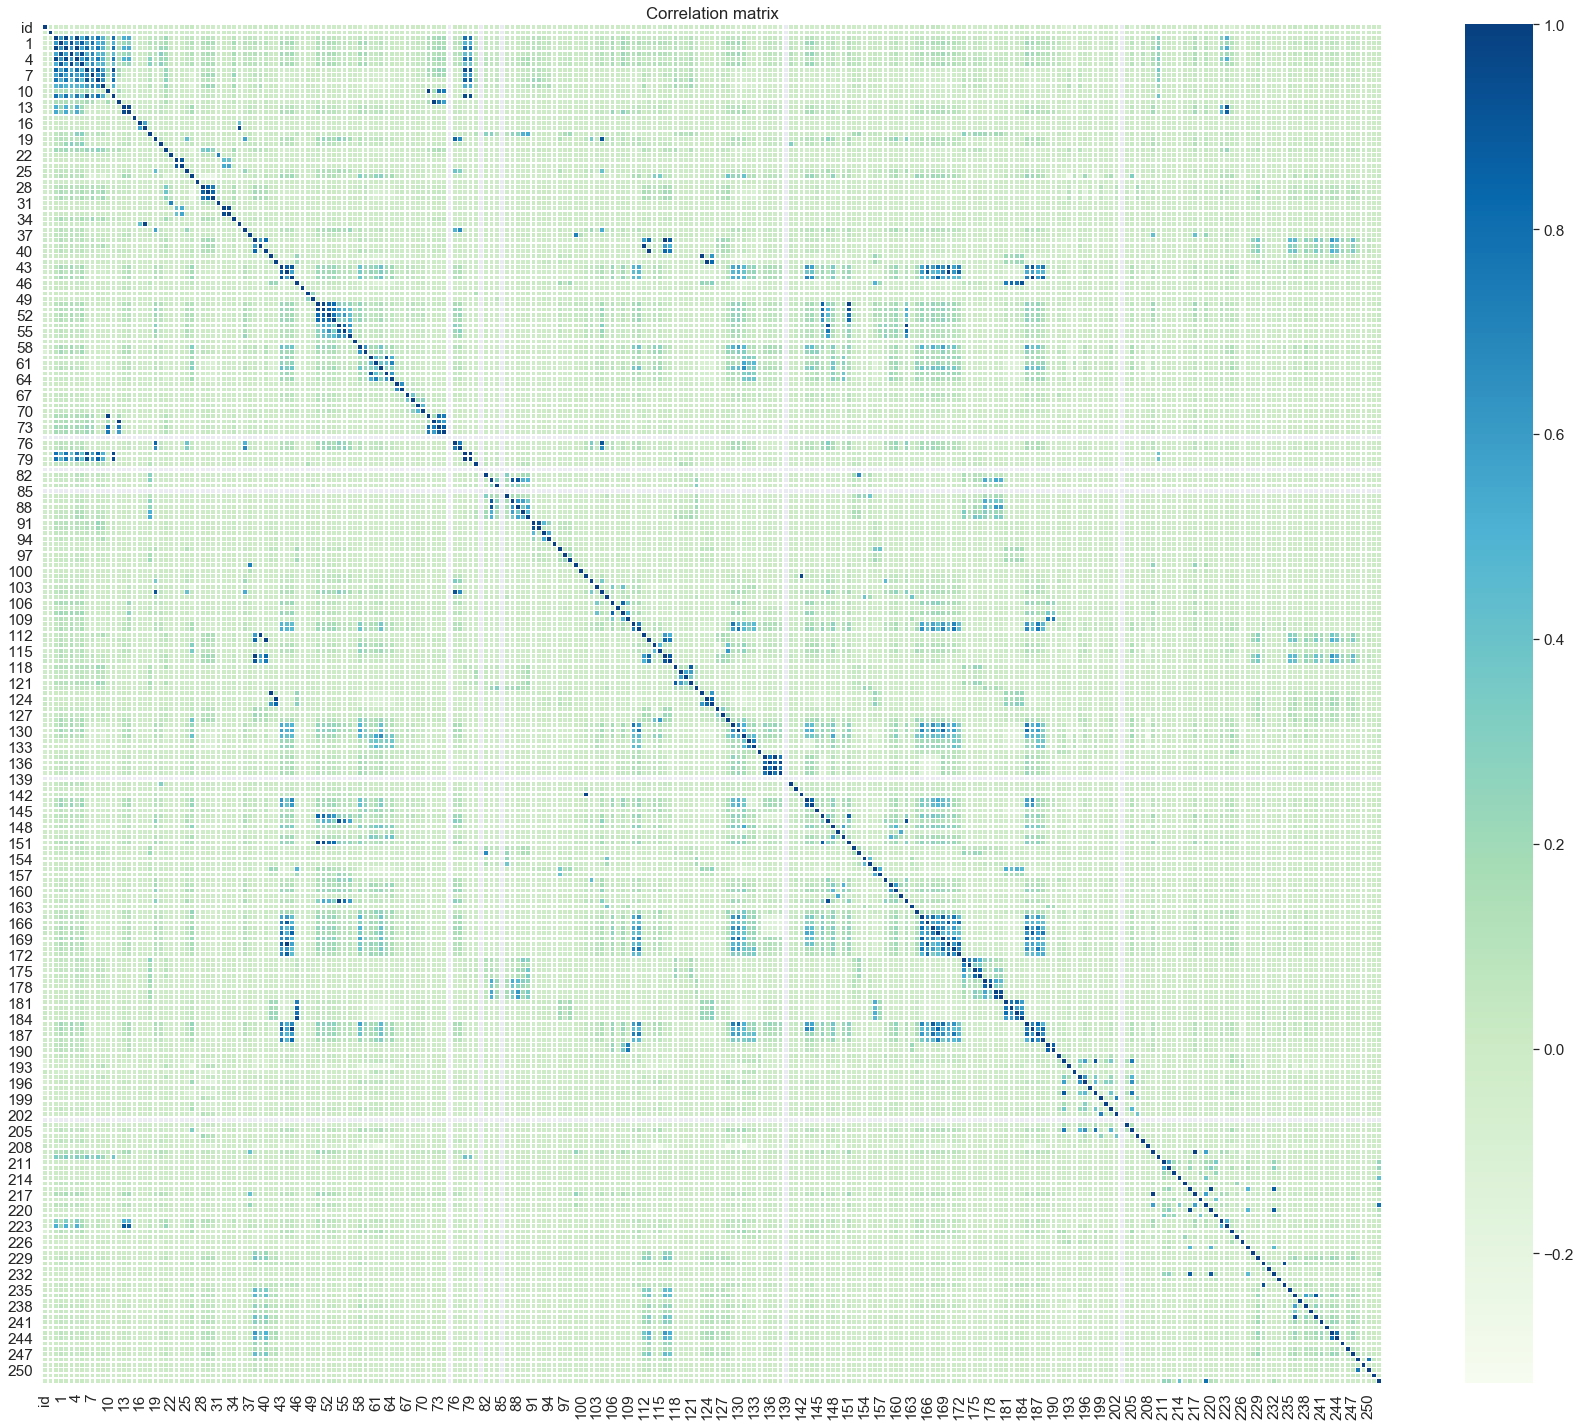

In [19]:
plt.figure(figsize = (30,25))

sns.set(font_scale=1.4)
sns.heatmap(df.BASE_FEATURE_NAMES.corr().round(3), linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

**Корреляция с базовыми признаками**

Наиболее высока линейная зависимость между целевой переменной и характером предлагаемой услуги. Если смотреть глубже, часть параметров пользователя оказывает слабое влияние на целевую переменную.

In [23]:
a = df.corr()
high_corr = a.loc[a[TARGET_NAME]>abs(0.01),TARGET_NAME]
high_corr

vas_id    0.262709
target    1.000000
Name: target, dtype: float64

##### Train Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
df.drop(['target'], axis=1),
df['target'],
test_size=0.3,
random_state=42)

##### Оценка моделей

In [26]:
models = []
models.append(RandomForestClassifier(n_estimators=150, max_depth=4, criterion='entropy'))
models.append(GradientBoostingClassifier(max_depth=4))
models.append(KNeighborsClassifier(n_neighbors=20, n_jobs=-1))
models.append(GaussianNB())
models.append(LogisticRegression())
models.append(xgb.XGBClassifier(random_state=21))
models.append(lgbm.LGBMClassifier(random_state=21))
models.append(catb.CatBoostClassifier(silent=True, random_state=21))

По точности прогнозов явное преимущество у ансамблей, основанных на алгоритме градиентного бустинга 

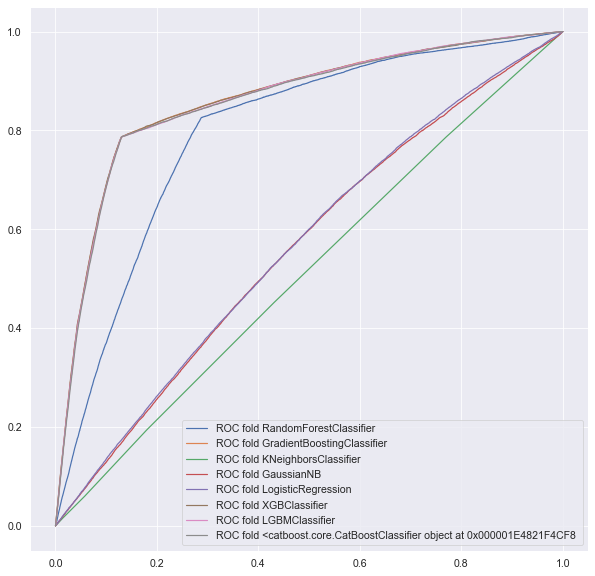

In [36]:
# Вывод Roc curve для каждой модели

plt.figure(figsize=(10, 10)) 
for model in models:
    model.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1], pos_label=1)
    md = str(model)
    md = md[:md.find('(')]
    plt.plot(fpr, tpr, label='ROC fold %s ' % (md))

plt.legend(loc="lower right")
plt.show()

In [126]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    
    """Просмотр отчетов отработки моделей из списка (classification report)"""
    
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [39]:
for model in models:
    print(f'MODEL NAME: {"*"*40} {model.__class__.__name__} {"*"*40}')
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    report = get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
    print(f'{report}')

MODEL NAME: **************************************** RandomForestClassifier ****************************************


C:\Users\Nickel\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



TRAIN

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    558322
         1.0       0.00      0.00      0.00     43714

    accuracy                           0.93    602036
   macro avg       0.46      0.50      0.48    602036
weighted avg       0.86      0.93      0.89    602036

TEST

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    239523
         1.0       0.00      0.00      0.00     18493

    accuracy                           0.93    258016
   macro avg       0.46      0.50      0.48    258016
weighted avg       0.86      0.93      0.89    258016

CONFUSION MATRIX

col_0      0.0
target        
0.0     239523
1.0      18493
None
MODEL NAME: **************************************** GradientBoostingClassifier ****************************************
TRAIN

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    558322
         1.0 

C:\Users\Nickel\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



TRAIN

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    558322
         1.0       0.00      0.00      0.00     43714

    accuracy                           0.93    602036
   macro avg       0.46      0.50      0.48    602036
weighted avg       0.86      0.93      0.89    602036

TEST

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    239523
         1.0       0.00      0.00      0.00     18493

    accuracy                           0.93    258016
   macro avg       0.46      0.50      0.48    258016
weighted avg       0.86      0.93      0.89    258016

CONFUSION MATRIX

col_0      0.0
target        
0.0     239523
1.0      18493
None
MODEL NAME: **************************************** GaussianNB ****************************************
TRAIN

              precision    recall  f1-score   support

         0.0       0.93      0.00      0.00    558322
         1.0       0.07      

### Выбор наилучшей модели
**Подбор гиперпараметров**

In [118]:
params = {'n_estimators':[50, 100, 150, 200], 
          'max_depth':[3, 5, 7],
          'learning_rate':[ 0.01, 0.05, 0.1],
          'l2_leaf_reg': [1, 3, 5, 7, 9]}

In [119]:
cv=KFold(n_splits=3, random_state=42, shuffle=True)

In [121]:
rs = RandomizedSearchCV(catb.CatBoostClassifier(), params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

0:	learn: 0.5892962	total: 72.8ms	remaining: 14.5s
1:	learn: 0.4987262	total: 83.8ms	remaining: 8.3s
2:	learn: 0.4397517	total: 95.3ms	remaining: 6.26s
3:	learn: 0.3874789	total: 106ms	remaining: 5.21s
4:	learn: 0.3546850	total: 122ms	remaining: 4.77s
5:	learn: 0.3202970	total: 134ms	remaining: 4.34s
6:	learn: 0.2869634	total: 145ms	remaining: 4s
7:	learn: 0.2641931	total: 158ms	remaining: 3.78s
8:	learn: 0.2551291	total: 168ms	remaining: 3.57s
9:	learn: 0.2370731	total: 180ms	remaining: 3.42s
10:	learn: 0.2205049	total: 194ms	remaining: 3.34s
11:	learn: 0.2124839	total: 206ms	remaining: 3.22s
12:	learn: 0.2008597	total: 217ms	remaining: 3.12s
13:	learn: 0.1972608	total: 228ms	remaining: 3.03s
14:	learn: 0.1908666	total: 247ms	remaining: 3.04s
15:	learn: 0.1832154	total: 260ms	remaining: 2.98s
16:	learn: 0.1785768	total: 274ms	remaining: 2.95s
17:	learn: 0.1752612	total: 286ms	remaining: 2.89s
18:	learn: 0.1707608	total: 302ms	remaining: 2.87s
19:	learn: 0.1681368	total: 318ms	remainin

168:	learn: 0.0960265	total: 2.45s	remaining: 450ms
169:	learn: 0.0958555	total: 2.46s	remaining: 435ms
170:	learn: 0.0954422	total: 2.48s	remaining: 420ms
171:	learn: 0.0951665	total: 2.49s	remaining: 405ms
172:	learn: 0.0948140	total: 2.5s	remaining: 390ms
173:	learn: 0.0945887	total: 2.51s	remaining: 376ms
174:	learn: 0.0943193	total: 2.53s	remaining: 361ms
175:	learn: 0.0940933	total: 2.54s	remaining: 346ms
176:	learn: 0.0939807	total: 2.55s	remaining: 332ms
177:	learn: 0.0936517	total: 2.56s	remaining: 317ms
178:	learn: 0.0935062	total: 2.58s	remaining: 302ms
179:	learn: 0.0932082	total: 2.59s	remaining: 288ms
180:	learn: 0.0929320	total: 2.6s	remaining: 273ms
181:	learn: 0.0927456	total: 2.61s	remaining: 258ms
182:	learn: 0.0922135	total: 2.63s	remaining: 244ms
183:	learn: 0.0918840	total: 2.64s	remaining: 229ms
184:	learn: 0.0914934	total: 2.65s	remaining: 215ms
185:	learn: 0.0911896	total: 2.67s	remaining: 201ms
186:	learn: 0.0909710	total: 2.68s	remaining: 186ms
187:	learn: 0.

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   error_score=nan,
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000020084CAD8D0>,
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 150, 200]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [122]:
rs.best_params_

{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'l2_leaf_reg': 1}

In [12]:
final_model = catb.CatBoostClassifier(n_estimators=200 ,max_depth=5, learning_rate=0.1,
                                      l2_leaf_reg=1, silent=True, random_state=42)
final_model.fit(X_train, y_train)

In [13]:
y_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)
f1_score(y_test, y_pred, average='macro')

0.6858371632451117

#### Балансировка признкаов

In [16]:
def get_best_balancing_ratio(X_train, y_train, X_test, y_test):
    
    """Выбор лучшего соотношения для балансировки"""
    
    score = []
    ratio = np.arange(0.2, 1, 0.1)
    best_ratio = 0
    
    print('Initial ratio:', Counter(y_train.values))

    for rat in ratio:

        ada = ADASYN(sampling_strategy=rat, random_state=42, n_jobs=-1)
        X_train_balanced, y_train_balanced = ada.fit_resample(X_train, y_train.values)    
        final_model.fit(X_train_balanced, y_train_balanced)
        y_pred = final_model.predict(X_test)
        sc = f1_score(y_test, y_pred, average='macro')
        score.append((rat, sc))
        print(f"Balancing values with ratio {round(rat, 1)}:...{Counter(y_train_balanced)}, score: {sc}")    

    for i, e in enumerate(score):
        if e[1] > best_ratio:
            best_ratio = round(e[0],1)
            
    print(f"\nBest ratio: {best_ratio}")
            
    return best_ratio

best_ratio = get_best_balancing_ratio(X_train[:10000], y_train[:10000], X_test, y_test)

Initial ratio: Counter({0.0: 9255, 1.0: 745})
Balancing values with ratio 0.2:...Counter({0.0: 9255, 1.0: 1842}), score: 0.6782663313053156
Balancing values with ratio 0.3:...Counter({0.0: 9255, 1.0: 2722}), score: 0.6798926580447522
Balancing values with ratio 0.4:...Counter({0.0: 9255, 1.0: 3819}), score: 0.6828507450980198
Balancing values with ratio 0.5:...Counter({0.0: 9255, 1.0: 4530}), score: 0.6827795497202287
Balancing values with ratio 0.6:...Counter({0.0: 9255, 1.0: 5598}), score: 0.6880766660745696
Balancing values with ratio 0.7:...Counter({0.0: 9255, 1.0: 6309}), score: 0.6879278771009989
Balancing values with ratio 0.8:...Counter({0.0: 9255, 1.0: 7477}), score: 0.6889477622830089
Balancing values with ratio 0.9:...Counter({0.0: 9255, 1.0: 8188}), score: 0.6861358481926758

Best ratio: (0.7, 2)


0.7

In [19]:
ada = ADASYN(sampling_strategy=best_ratio, random_state=42, n_jobs=-1)
X_train_balanced, y_train_balanced = ada.fit_resample(X_train, y_train.values)

In [20]:
final_model.fit(X_train_balanced, y_train_balanced)
y_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)
f1_score(y_test, y_pred, average='macro') # без балансировки 0.685...

0.6933135397357093

#### Оценка параметров модели

In [89]:

"""Блок отрисовки результатов отработки модели"""


def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    """Строит кривую обучения"""

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(20,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    
    """Выводит кривую калибровки целевой переменной"""
    
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (20, 6))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.25, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()
    
def show_feature_importances(feature_names, feature_importances, get_top=10):
    
    """Выводит рейтинг категорий по влиянию на на результат работы модели"""
    
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)[:get_top]
    
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show() 

    return feature_importances['feature'][:get_top].tolist()

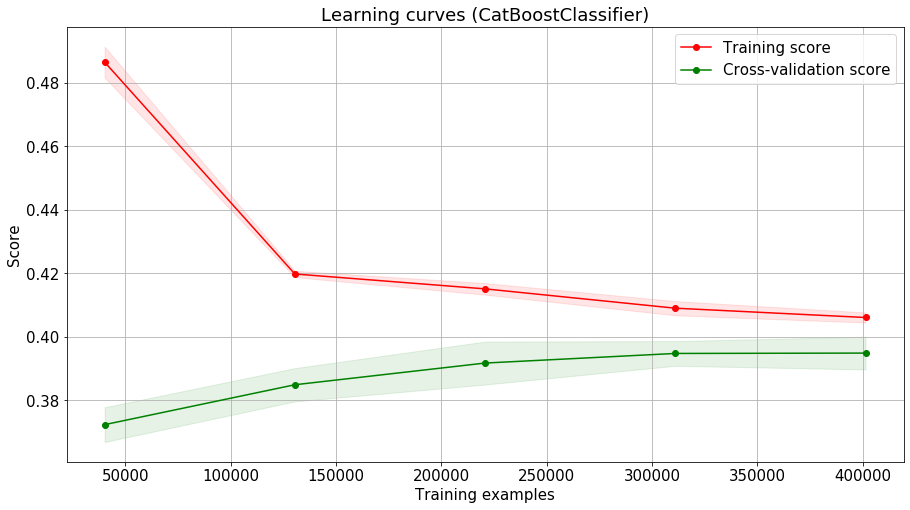

In [27]:
show_learning_curve_plot(final_model, X_train, y_train)

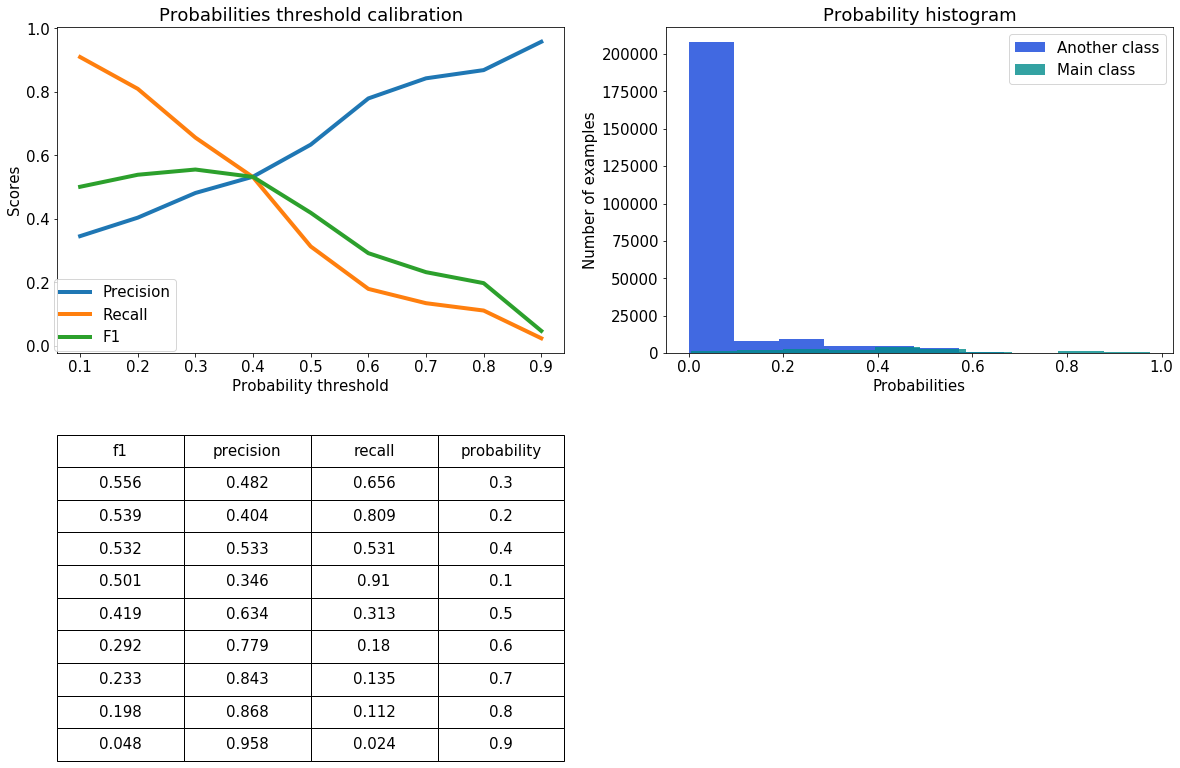

In [69]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

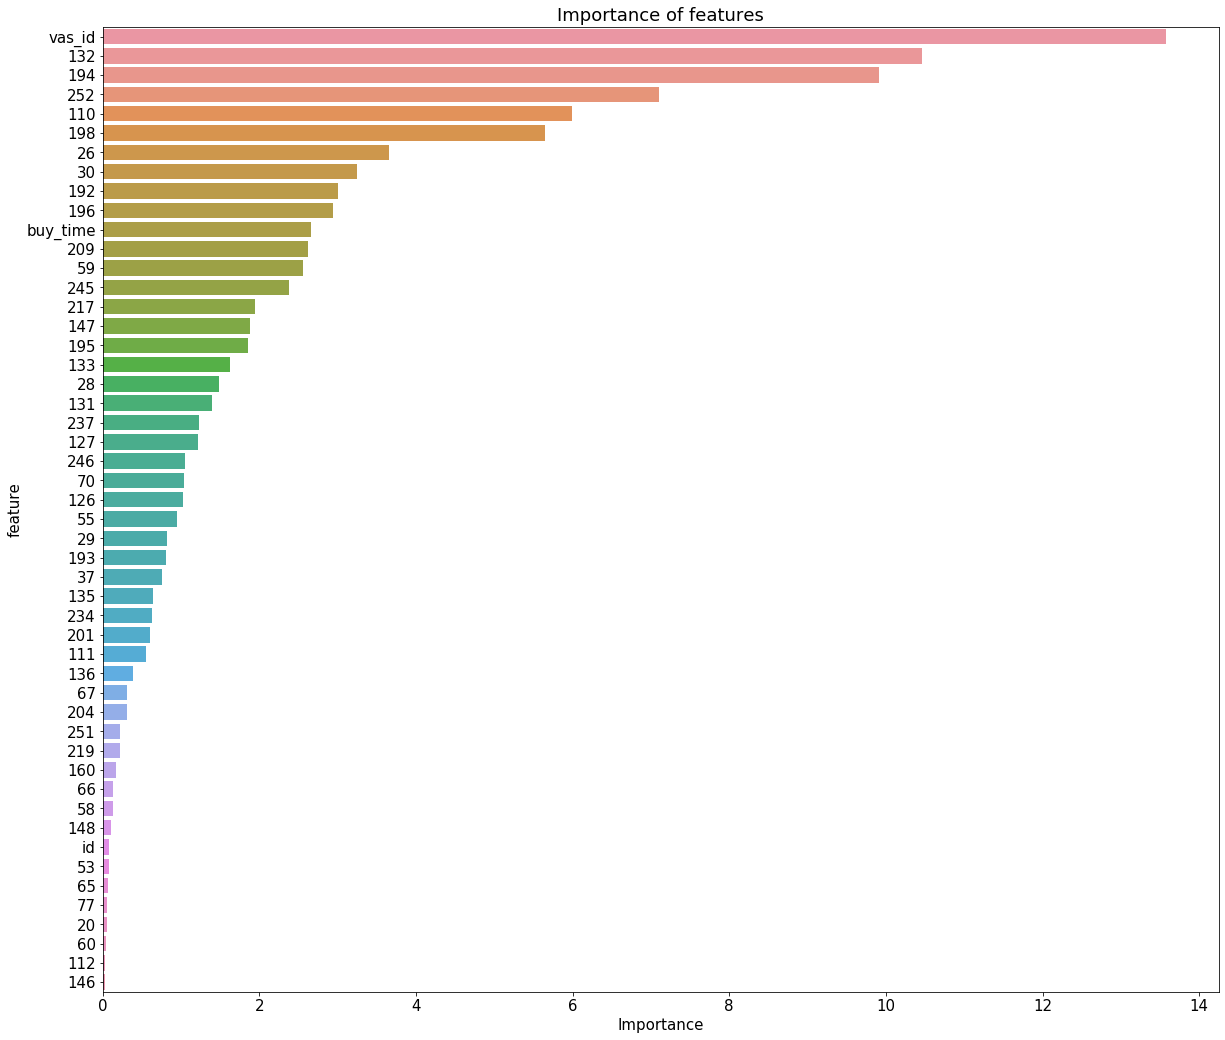

In [88]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=50)

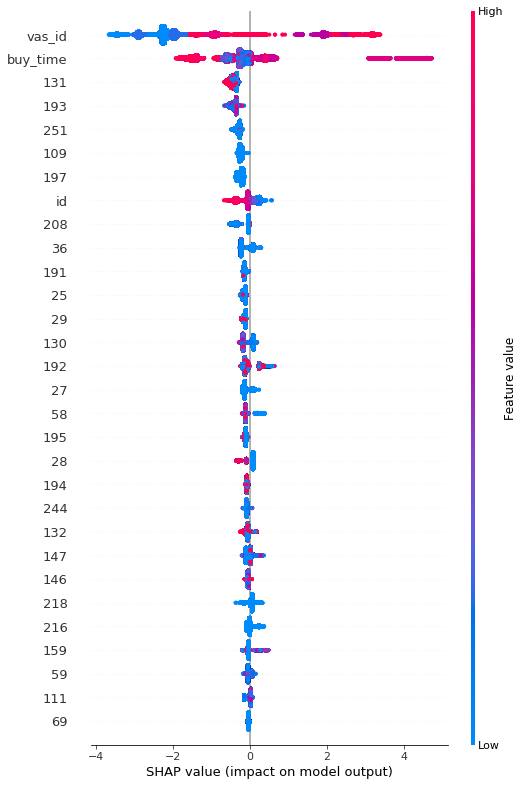

In [90]:
shap_test = shap.TreeExplainer(final_model).shap_values(df)
shap.summary_plot(shap_test, df, max_display=30)

Confusion matrix, without normalization
[[236174   3349]
 [ 12696   5797]]


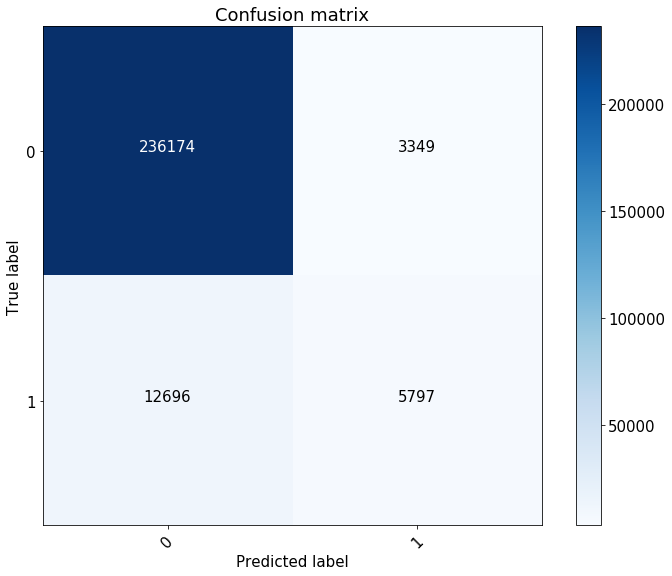

In [70]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Визуализация confusion matrix.
    Дополнительно возможно использование нормализаци, выставив значение `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, final_model.predict(X_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [127]:
fm_y_train_pred = final_model.predict(X_train)
fm_y_test_pred = final_model.predict(X_test)
report = get_classification_report(y_train, fm_y_train_pred, y_test, fm_y_test_pred)
print(f'{report}')

TRAIN

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    558322
         1.0       0.65      0.32      0.43     43714

    accuracy                           0.94    602036
   macro avg       0.80      0.65      0.70    602036
weighted avg       0.93      0.94      0.93    602036

TEST

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    239523
         1.0       0.63      0.31      0.42     18493

    accuracy                           0.94    258016
   macro avg       0.79      0.65      0.69    258016
weighted avg       0.93      0.94      0.93    258016

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     236174  3349
1.0      12696  5797
None


In [93]:
# Сохранение модели

MODEL_FILENAME = 'final_model.sav'
pickle.dump(final_model, open(MODEL_FILENAME, 'wb'))

In [ ]:
# Загрузка модели и предсказание на тестовых данных

"""Принимает из корневой директории data_test.csv, 
в качестве опорных данных использует features.csv из корневой директории
Записывает answers_test.csv

столбцы: ['date', 'msisdn', 'vas_id', 'target']"""

test_file = 'data_test.csv'
feature_file = 'features.csv'

In [ ]:
class prediction_Pipeline(luigi.Task):
    file = luigi.Parameter()
    
    def run(self):
        data = pd.read_csv(self.file)
        data = data.rename(columns={'Unnamed: 0': 'index'})
        data = data.set_index('index')
        data['date'] = pd.to_datetime(data['buy_time'], unit='s')
        data['is_holiday'] = data['date'].map(lambda x: x in holidays.RU())
        df = []
        for gm_chunk in pd.read_csv('features.csv',sep='\t',chunksize=chunksize):
            df.append(data.merge(gm_chunk,  on=('id','buy_time')))
        df_merged = pd.concat(df)
        data_prelim = df_merged.copy()
        X = data_prelim.drop(['buy_time','date','Unnamed: 0'], axis=1)
        X = X.set_index('id')
        target = lg_fs_pipe_final.predict_proba(X)[:,1]
        data_prelim['target'] = target>0.5
        data_prelim.loc[:,['buy_time', 'id', 'vas_id', 'target']].to_csv("answers_test.csv",index=None)

In [ ]:
if __name__ == '__main__':
    luigi.build([MyTask()])

In [9]:
# MODEL_FILENAME = 'final_model.sav' # 

with open(MODEL_FILENAME='final_model.sav', 'rb') as input_file:
    model = pickle.load(input_file)

In [95]:
data = prepare_dataset(test_file, feature_file='features.csv')

In [268]:
data.rename(columns={'buy_time_x': 'buy_time'}, inplace=True)
# X = data.drop(['buy_time_x', 'buy_time_y'], axis=1)

In [269]:
data['target'] = model.predict(X)

In [270]:
data.loc[:,['id','vas_id', 'buy_time', 'target']].to_csv('answers_test.csv')

#### Формирование индивидуального предложения клиенту

In [15]:
from tensorflow import keras
import tensorflow as tf

In [26]:
df['buy_time'] = (df['buy_time'].astype('int64') / 10**9).astype('int64') # Back to timestamp

In [28]:
Xn = df.drop(['target'], axis=1)

yn = df['target']

In [32]:
best_ratio = 0.9
ada = ADASYN(sampling_strategy=best_ratio, random_state=42, n_jobs=-1)
Xn_balanced, yn_balanced = ada.fit_resample(Xn, yn.values)

In [55]:
# xdf = Xn_balanced.copy()
# xdf['target'] = yn_balanced

dfn = df.copy()

# Используем только значения с таргетом = 1
dfn = dfn.loc[dfn['target']==1]

In [56]:
dfn.target.value_counts()

1.0    684
Name: target, dtype: int64

In [63]:
label_names = dfn['vas_id'].unique().astype(np.uint8)

In [64]:
label_names

array([4, 5, 2, 6, 1, 9, 8], dtype=uint8)

In [91]:
feature_columns = dfn.columns[4:]

X = dfn[feature_columns].values
y = dfn['vas_id'].values

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [93]:
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [94]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [96]:
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
478/478 [==============================] - 0s 86us/sample - loss: 15.3088 - acc: 0.0502
Epoch 2/100
478/478 [==============================] - 0s 100us/sample - loss: 15.3088 - acc: 0.0502
Epoch 3/100
478/478 [==============================] - 0s 103us/sample - loss: 15.3088 - acc: 0.0502
Epoch 4/100
478/478 [==============================] - 0s 84us/sample - loss: 15.3088 - acc: 0.0502
Epoch 5/100
478/478 [==============================] - 0s 92us/sample - loss: 15.3088 - acc: 0.0502
Epoch 6/100
478/478 [==============================] - 0s 100us/sample - loss: 15.3088 - acc: 0.0502
Epoch 7/100
478/478 [==============================] - 0s 167us/sample - loss: 15.3088 - acc: 0.0502
Epoch 8/100
478/478 [==============================] - 0s 84us/sample - loss: 15.3088 - acc: 0.0502
Epoch 9/100
478/478 [==============================] - 0s 100us/sample - loss: 15.3088 - acc: 0.0502
Epoch 10/100
478/478 [==============================] - 0s 109us/sample - loss: 15.3088 - acc: 

In [97]:
model.evaluate(X_test, y_test)

206/206 [==============================] - 0s 466us/sample - loss: 15.4921 - acc: 0.0388


[15.492149899306806, 0.03883495]

In [102]:
predictions = model.predict(X_test)
print(f'probability matrix:\n{predictions[0]}\n')
print(f'predicted value:\n{np.argmax(predictions[0])}\n')
print(f'true value:\n{y_test[0]}\n')
print(f'class name:\n{label_names[np.argmax(predictions[0])]}')

probability matrix:
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

predicted value:
5

true value:
6.0

class name:
9


In [65]:
dfn.head()

,id,vas_id,buy_time,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
2,540997,4.0,1542574800,1.0,-96.799973,-69.199112,-108.200783,-112.916801,-113.618248,-134.021790,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-11.400815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-192.026962,-2922.876953,-1186.295166,-1736.581787,-89.504288,-119.724358,-118.428688,-54.602524,-63.826160,-7.896282,-7.997875,-10.717958,-28.571102,-27.130283,-31.088985,-57.171711,-28.331295,-3.958702,-8.745251,-1.671324,-0.001656,-19.681646,0.117335,-0.265234,0.141838,-0.091644,-0.237576,0.204338,-0.028454,-0.044465,-0.301128,-0.554677,-0.036834,-0.130031,-2.783592,-2.60662,-5.390212,-4.022547,0.0,-2.824022,-10.706438,-1.2015,-0.998268,-0.203232,0.0,-0.248755,-0.222852,-0.134088,0.0,-0.030537,-0.125866,-0.096986,-0.679774,-0.626985,-0.691912,-0.506613,-0.185299,-0.598716,-0.000115,-0.250188,-0.348913,-0.828382,-42.275913,-3.950157,-0.253037,-0.318148,-2.290640,-3.447583,-0.040043,-9.408469,-0.212137,-11.955315,-1.019293,-2.473446,-4.62084,-1187.490967,-1738.718506,-0.36799,0.556143,-2926.209473,-2279.622559,-0.343415,-0.08972,-0.278878,-0.433135,-0.024048,-89.211945,-119.674408,-208.886353,-0.058077,-0.060451,0.374871,-5.618165,-12.681642,-2.573283,0.531558,0.582717,-190.67038,-1.143223,1.277409,-0.825973,1.064012,0.0,-1.276187,-0.020137,-0.042636,-29.797016,-116.020805,34.036369,-17.888325,-3.861461,-0.317164,-0.007024,-0.143269,-24.417671,-0.212646,-0.019562,-0.000044,-0.000379,-2.548856,-0.261309,-0.536315,-0.061481,-0.152157,-0.002595,-3.678214,-0.014542,0.270492,-21.183167,-44.376427,-25.320086,-51.984825,-25.961227,-54.662235,-13.614497,-30.821720,-0.028857,-0.063214,-0.019198,-0.033778,-0.003149,-0.005184,-0.001431,-0.00189,-1.257363,-2.793638,-1.932758,-5.008096,-29.978121,-63.867386,-15.354808,-34.070370,-0.034569,-0.163184,-109.036400,0.533317,3.070952,0.376263,-0.228106,0.748041,-0.000567,-0.433736,-0.000708,0.97079,-0.104665,-0.001358,0.0,0.039208,-0.334356,-0.008999,12954.353516,-45175.257812,-0.622901,-30.716053,-61790.156250,-0.243136,-41221.167969,-9239.707031,-2.108050,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,973015680.0,-57.274078,973867136.0,-1.204418e+08,9.899332,-1.465191,-32.30238,-265.128998,-39.772491,-0.364694,-0.133771,-0.209468,-35.356506,-109.884567,-875.69104,-5.368281,-247.110703,-108.409744,-511.437317,-106.617981,-4.295406,-977.37384,-613.770813,-25.996269,-37.630447,-306.747711,-24.832888,0.305571,-12.175933,-0.45614,0.0
23,3684312,5.0,1542574800,1.0,221.000031,-90.379112,215.949219,-107.426796,210.531754,-128.531784,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,251.610870,240.281891,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-5.050815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,207.973038,-2942.440430,-1186.765869,-

In [309]:
labels

array([2, 1, 4, 5, 8, 6, 7, 9], dtype=uint8)

In [279]:
prob_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

Instructions for updating:
Colocations handled automatically by placer.


In [283]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Object `model.compile(optimizer=tf.train.AdamOptimizer(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])` not found.


In [ ]:
"""Создать pdf презентацию (5-10 слайдов)

1.Информация о модели, ее параметрах,
особенностях и основных результатах.

2.Обоснование выбора модели и ее
сравнение с альтернативами.

3.Принцип составления индивидуальных
предложений для выбранных абонентов"""